In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

(ch:pa_modeling)=
# Creating a Model to Correct PurpleAir Measurements 

Now that we've matched together PM2.5 readings from AQS and PurpleAir sensors,
we're ready for the final step of the analysis: creating a model that
calibrates PurpleAir measurements.
Barkjohn's original analysis fits many models to the data in order to find
the most appropriate one.
In this section, we'll start by fitting several simpler models
using the techniques from the {ref}`ch:modeling` chapter.
Then, we'll fit a few models from Barkjohn's analysis, including the final
model they chose for real-world use.
Since the final model uses methods that we introduce later in the book,
we won't explain the technical details very deeply here---we
instead encourage you to revisit this section after reading the
{ref}`ch:linear_models` and {ref}`ch:mult_intro` chapters.

## Loading in the Data

Let's begin by loading in the cleaned dataset of matched AQS and PurpleAir
PM2.5 readings.
We do some data processing as we load in the CSV file. 
Since this section focuses on modeling, we've left it as an exercise to
understand what the code does.

In [259]:
csv_file = 'data/cleaned_purpleair_aqs/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'TempC', 'RH', 'Dewpoint']
full = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'temp', 'rh', 'dew']
full

,date,id,region,pm25aqs,pm25pa,temp,rh,dew
0,2019-05-17,AK1,Alaska,6.7,8.62,18.03,38.56,3.63
1,2019-05-18,AK1,Alaska,3.8,3.49,16.12,49.40,5.44
2,2019-05-21,AK1,Alaska,4.0,3.80,19.90,29.97,1.73
...,...,...,...,...,...,...,...,...
12427,2019-02-20,WI6,North,15.6,25.30,1.71,65.78,-4.08
12428,2019-03-04,WI6,North,14.0,8.21,-14.38,48.21,-23.02
12429,2019-03-22,WI6,North,5.8,9.44,5.08,52.20,-4.02


We've included an explanation for each of the columns below.

| Column  | Description                                                                                                                      |
|---------|----------------------------------------------------------------------------------------------------------------------------------|
| date    | Date of the observation                                                                                                          |
| id      | A unique label for a site, formatted as the US state abbreviation with a number. (We performed data cleaning for site ID `CA1`.) |
| region  | The name of the region, which corresponds to a group of sites. (The `CA1` site is located in the `West` region.)                 |
| pm25aqs | The PM2.5 measurement from the AQS sensor.                                                                                       |
| pm25pa  | The PM2.5 measurement from the PurpleAir sensor.                                                                                 |
| temp    | Temperature, in Celcius.                                                                                                         |
| rh      | Relative humidity, ranging from 0 to 100%.                                                                                       |
| dew     | The dew point of the air. (Higher dew point means more moisture in the air.)                                                     |

Before we start modeling, we want to understand the data.
We'll start by making some simple visualizations.
First, we'll make a plot of the weekly average AQS PM2.5 over time.

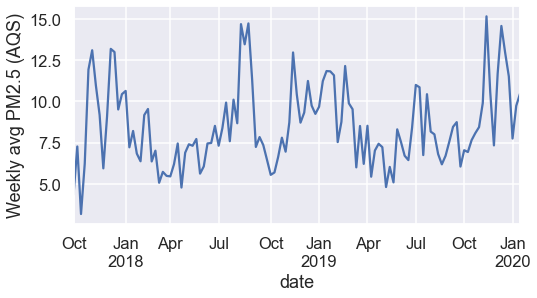

In [261]:
plt.figure(figsize=(8, 4))

(full.set_index('date')
 .resample('W')
 ['pm25aqs']
 .mean()
 .plot()
)

plt.ylabel('Weekly avg PM2.5 (AQS)');


We see that most PM2.5 values range between 5.0 and 15.0 µg m⁻³.

Next, we'll plot the distribution of both AQS and PurpleAir PM2.5 readings.

In [262]:
def plot_dist(col):
    # We need to make sure the x- and y-axes have the same limits for both plots,
    # or else the plots will be difficult to compare
    sns.displot(data=full, x=col, stat='density',
            kde=True, aspect=3, height=3)
    plt.xlim([0, 60])
    plt.ylim([0, 0.11])

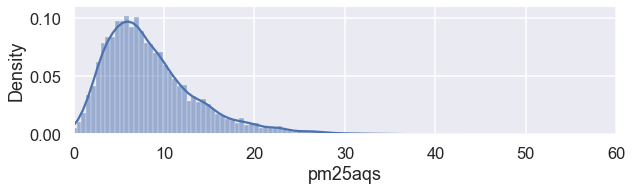

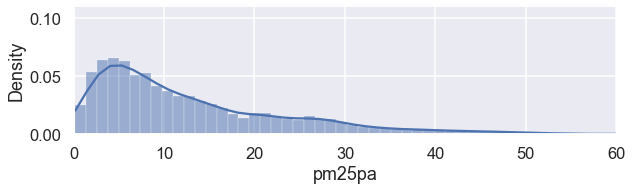

In [263]:
# We need to make sure the x- and y-axes have the same limits for both plots,
# or else the plots will be difficult to compare
plot_dist('pm25aqs')
plot_dist('pm25pa')

We see that the distributions of PM2.5 readings are skewed to the right. 

Lastly, we'll plot PurpleAir against AQS readings.

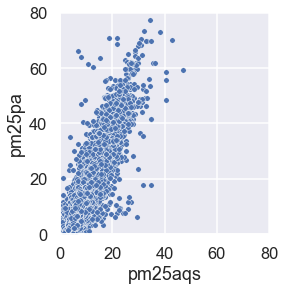

In [264]:
sns.relplot(data=full, x='pm25aqs', y='pm25pa', s=30, aspect=1, height=4);
plt.xlim([0, 80])
plt.ylim([0, 80]);

Before starting this analysis, we expected that PurpleAir measurements
would generally overestimate the PM2.5. 
And indeed, this is reflected in the scatter plot.

## Our Modeling Procedure

First, let's go over our modeling goals.
We want to create a model that predicts PM2.5 as
accurately as possible.
To do this, our model can make use of the PurpleAir measurements, as well as
the other variables in the data, such as the ambient temperature and relative
humidity.

Here, we treat the AQS measurements as the true PM2.5 values.
The AQS measurements are taken from carefully calibrated instruments and are
actively used by the US government for decision-making, so we have reason to
trust that the AQS PM2.5 values are accurate.

We plan to fit and compare several models on the data.
To do so, we first randomly split the data in `full` into a
training and testing set.
For all of our models, we'll fit the model on the training set and report
the root mean squared error (RMSE) on the test set.
Intuitively, the held-out test set mimics new measurements
that the model "doesn't see" while we fit it.
This means that we can treat the test set error as an
estimator for the model's real-world performance.

We'll set aside 1000 observations aside for the test set.

In [265]:
np.random.seed(42)

n = len(full)
test_n = 1000

# Shuffle the row labels
shuffled = np.random.choice(n, size=n, replace=False)

# Split the data
test  = full.iloc[shuffled[:test_n]]
train = full.iloc[shuffled[test_n:]]
train

,date,id,region,pm25aqs,pm25pa,temp,rh,dew
2685,2019-04-25,CA2,West,7.17,8.06,22.99,48.33,11.46
10214,2018-08-30,NC4,Southeast,12.60,23.13,33.01,46.22,19.98
10516,2019-08-14,VT1,North,6.78,8.70,25.44,49.25,14.01
...,...,...,...,...,...,...,...,...
5402,2019-10-10,GA1,Southeast,6.70,11.99,23.52,60.24,15.35
861,2019-01-31,AZ1,Central Southwest,9.40,10.98,20.90,29.33,2.31
7282,2018-08-10,IA2,North,18.67,43.22,29.60,50.17,18.15


We also plan to evaluate each model's predictions on the test set,
so we'll define a function to compute the RMSE of a set of predictions.

In [266]:
def rmse(predictions):
    return np.sqrt(np.mean((test['pm25aqs'] - predictions)**2))

In [267]:
def model_results(models):
    results = [
        [model.__doc__, rmse(model(train)(test))]
        for model in models
    ]
    return (pd.DataFrame(results, columns=['model', 'rmse'])
            .set_index('model'))

## Model 1: A Simple Constant Model

Now, let's fit our first model---a constant model like the ones we
worked with in the previous {ref}`ch:modeling` chapter.
Constant models only predict one number.
That is, our model $ f_{\theta}(x) $ is:

$$
\begin{aligned}
f_{\theta}(x) = {\theta}
\end{aligned}
$$

For example, if we set $ \theta = 5.5 $, then the model would predict
that the AQS PM2.5 reading is always 5.5.

In our previous discussion of the constant model, we found that we minimize
the mean squared error when we set $ \hat{\theta} $ to the mean of the
response variable.
In this case, we set $ \hat{\theta} $ to the mean AQS PM2.5 value, and
our model is simply:

$$
\begin{aligned}
f_\hat{\theta}(x) = \text{mean(aqs)}
\end{aligned}
$$


In [268]:
def model_1(train):
    '''f(x) = θ'''
    mean = train['pm25aqs'].mean()
    def predict(data):
        return np.repeat(mean, len(data))
    
    return predict

Now, we can fit the model on the training set and check its accuracy on the
test set.

In [269]:
predict = model_1(train)
rmse(predict(test))

5.446107182896083

We've found that this simple model has a loss of 5.45 µg m⁻³.
Intuitively, this means that the model will usually be around 5.45 µg m⁻³
away from the actual AQS measurement.
We can see this when we mark the mean on the distribution
of AQS readings.

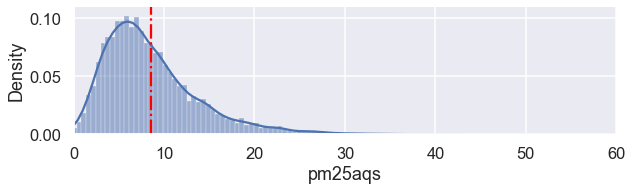

In [270]:
mean = train['pm25aqs'].mean()
plot_dist('pm25aqs')
plt.axvline(mean, c='red', linestyle='-.');
# Most points are within 5.36 µg m⁻³ away from the mean

This model is too simple to use in practice---it performs especially badly
when PM2.5 values are high, which is exactly where we care about model
accuracy the most!
Still, this serves as a useful baseline for future models and demonstrates
our modeling procedure.

## Model 2: Adjusting PurpleAir by a Constant

Let's fit a constant again, but with a twist: we'll fit a model
that adjusts PurpleAir measurements by a constant rather than simply
outputting the average AQS measurement.
Our model is:

$$
\begin{aligned}
f_{\theta}(x_i) = \text{PA}_i + \theta
\end{aligned}
$$

In this model, $ \text{PA}_i $ represents the PurpleAir measurement
for a row $ x_i $ in the data, and $ \theta $ is a constant we once again
need to fit.

We want to minimize the mean squared loss.
Let $ \text{AQS}_i $ denote the AQS reading for row $ x_i $ of the data.
Then, the mean squared loss is:

$$
\begin{aligned}
L(\theta) &= \frac{1}{n} \sum_i (\text{AQS}_i - f_{\theta}(x_i))^2 \\
&= \frac{1}{n} \sum_i (\text{AQS}_i - (\text{PA}_i + \theta))^2
\end{aligned}
$$

To minimize the loss, we can derive that
$ \hat{\theta} = \frac{1}{n} \sum_i(\text{AQS}_i - \text{PA}_i) $.
In other words, $ \hat{\theta} $ is the mean difference between
AQS and PurpleAir readings.
We've left the derivation as an exercise for the reader.
After fitting on the training data, we have $ \hat{\theta} = -4.86 $:

In [271]:
np.mean(train['pm25aqs'] - train['pm25pa'])

-4.859246747707521

With this, we can implement our second model.

In [272]:
def model_2(train):
    '''f(x) = PA + θ'''
    mean_diff = np.mean(train['pm25aqs'] - train['pm25pa'])
    def predict(data):
        return data['pm25pa'] + mean_diff
    
    return predict

To compare our models, we've written a small helper function called
`model_results` that outputs the models and their RMSE on the test set.
We'll call this function to compare the results of the two models we've
defined thus far.

In [273]:
model_results([model_1, model_2])

,rmse
model,
f(x) = θ,5.45
f(x) = PA + θ,7.33


### Why Did Model 2 Perform Worse?

Surprisingly, the second model has a worse RMSE than the first.
Why did this happen?
One way to diagnose these models is to subtract the model's
predictions from the actual observed AQS values.
These differences are called the *residuals*.

In [129]:
def residuals(model):
    predict = model(train)
    return test['pm25aqs'] - predict(test)

Let's plot the residuals for both models and compare.

In [274]:
def plot_residuals(models):
    model_names = pd.Index([model.__name__ for model in models], name='model')
    resids = (pd.concat(
        [test.assign(resid=residuals(model)) for model in models],
        keys=model_names).reset_index(level=0))
    
    g = sns.relplot(data=resids, x='pm25pa', y='resid',
                    col='model', col_wrap=3, aspect=0.8,
                    s=30)
    g.map(lambda **k: plt.axhline(y=0, color='black', linestyle=":"))
    g.set_xlabels('PA')
    g.set_ylabels('residuals')

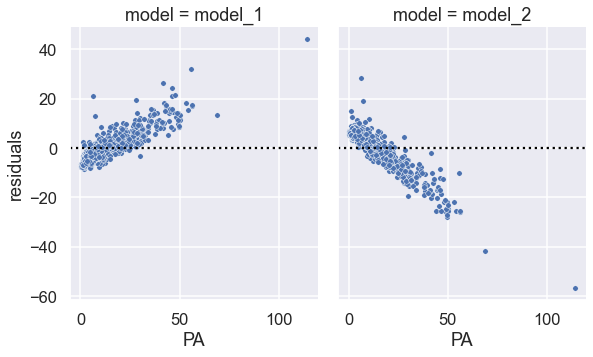

In [275]:
plot_residuals([model_1, model_2])

Note that a residual of 0 means that the model correctly predicted
the PM2.5. A positive residual means the model underestimated PM2.5, and
a negative residual means the model overestimated PM2.5. 

We see that both models perform poorly at higher PM2.5 measurements.
Model 1, the simple constant model, tends to underestimate PM2.5.
Likewise, Model 2, the model that adjusts PurpleAir by a constant, tends
to overestimate PM2.5.

We saw earlier in this section that PurpleAir sensors tend to overestimate
PM2.5.
However, subtracting a constant value doesn't seem to do enough to
correct PurpleAir readings.

Next, we'll fit linear models on the data.
In this book, we cover linear models
in later chapters (Chapters {numref}`%s <ch:linear_models>` and
{numref}`%s <ch:mult_intro>`).
However, we include linear models in this section in order to match
Barkjohn's analysis, and to produce the final model that is currently
in real-world use.

## Model 3: Simple Linear Regression

Making a scatter plot of PurpleAir and AQS measurements shows that a linear
model can be appropriate:

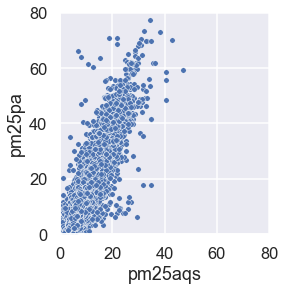

In [276]:
sns.relplot(data=full, x='pm25aqs', y='pm25pa', s=30, aspect=1, height=4);
plt.xlim([0, 80])
plt.ylim([0, 80]);

By eyeballing this plot, we might guess that
the PurpleAir PM2.5 is about twice as high as the actual PM2.5.
This idea is encapsulated in the simple linear model:

$$
\begin{aligned}
f_{\theta}(x_i) = \theta_0 + \theta_1 \text{PA}_i
\end{aligned}
$$


To predict the PM2.5, this model multiplies the PurpleAir measurements
by $ \theta_1 $, then adds a constant $ \theta_0 $.

### Using a Linear Model for Calibration 

This is a **calibration** scenario.
We have PurpleAir sensors which we want to calibrate to match AQS sensors.
Then, we can adjust the PurpleAir readings using the correction we get
from calibration.

This is a two-step procedure:

1. Fit a calibration model that uses AQS measurements to predict PurpleAir measurements.
2. *Invert* the model to find $ \hat \theta_1 $ and $ \hat \theta_0 $.

In other words, we'll fit this model first:

$$
\begin{aligned}
\text{predicted } \text{PA}_i = b + m \cdot \text{AQS}_i
\end{aligned}
$$

Then, we invert this model:

$$
\begin{aligned}
\text{PA}_i &= \hat b + \hat m \cdot \text{AQS}_i \\
\text{PA}_i - \hat b &= \hat m \cdot \text{AQS}_i \\
\text{AQS}_i &= \frac{1}{\hat m} \text{PA}_i - \frac{\hat b}{\hat m}
\end{aligned}
$$

Which gives $ \hat \theta_1 = \frac{1}{\hat m} $ and
$ \hat \theta_0 = - \frac{\hat b}{\hat m} $

:::{admonition} Why invert the model?

This procedure might seem a bit roundabout.
Why not fit a linear model for $ f_{\theta}(x) $
that uses PurpleAir to predict AQS directly?
This would get $ \hat \theta_1 $ and $ \hat \theta_0 $ without
needing to invert anything.

Intuitively, linear models assume that the explanatory variable, or the variable
we put on the x-axis, has no error.
Linear models also assume that all the error occurs when we measure the response
variable, or the variable we put on the y-axis.
Thus, during calibration we treat the AQS measurements as the x-axis variable
since these measurements have relatively little error.
This allows us to model the error in PurpleAir measurements.
If we fit $ f_{\theta}(x) $ directly, we'll say the opposite:
that the measurement error happens in the AQS readings rather than PurpleAir
readings.

As a simpler example, let's say we're calibrating a weight scale.
We could do this by first placing known weights---say 1 kg, 5 kg,
and 10 kg---onto the scale, and seeing what the scale reports.
Analogously, the AQS measurements are the known quantities, and we check
what the PurpleAir sensors report.

For a more rigorous treatment of statistical calibration,
see {cite}`osborneStatistical1991`.

:::

Now, let's define the model.

In [277]:
from sklearn.linear_model import LinearRegression

def model_3(train):
    '''f(x) = θ₀ + θ₁PA'''
    # Fit calibration model using sklearn
    X, y = train[['pm25aqs']], train['pm25pa']
    model = LinearRegression().fit(X, y)
    m, b = model.coef_[0], model.intercept_
    
    # Invert model
    theta_1 = 1 / m
    theta_0 = - b / m
    
    def predict(data):
        return theta_0 + theta_1 * data['pm25pa']
    return predict

In [278]:
model_results([model_1, model_2, model_3])

,rmse
model,
f(x) = θ,5.45
f(x) = PA + θ,7.33
f(x) = θ₀ + θ₁PA,2.96


We see that the linear model performs considerably better than the
other models we've done.
This is reflected in the residuals:

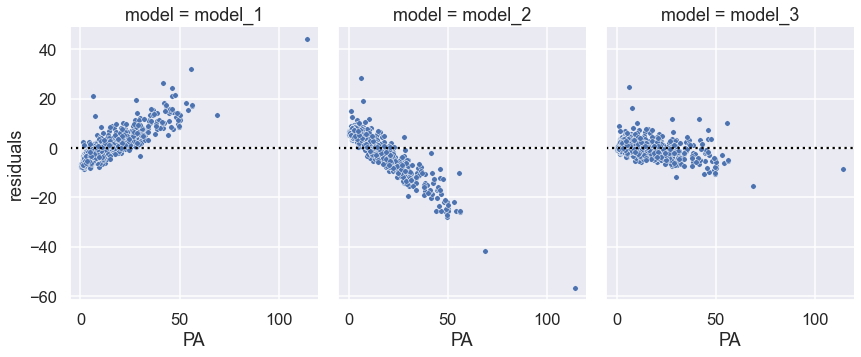

In [279]:
plot_residuals([model_1, model_2, model_3])

Happily, the residuals of the linear model shows that it still performs
relatively well even when PM2.5 is high.

Under this model, $ \hat \theta_1 = 0.52 $ and $ \hat \theta_0 = 1.54 $, so our
fitted model predicts:

$$
\begin{aligned}
f_{\hat \theta}(x) = 1.54 + 0.52 \text{PA}
\end{aligned}
$$

## Model 4: Incorporating Relative Humidity

The final model that Barkjohn selected was a linear model that also incorporated
the relative humidity:

$$
\begin{aligned}
f_{\theta}(x_i) = \theta_0 + \theta_1 \text{PA}_i + \theta_2 \text{RH}_i
\end{aligned}
$$

Here, $ \text{PA}_i $ and $ \text{RH}_i $ refer to the PurpleAir PM2.5 and the
relative humidity for row $ x_i $ of the data.
This is an example of a multivariable linear regression model---it uses
more than one variable to make predictions.

As before, we'll fit the calibration model first:

$$
\begin{aligned}
\text{predicted } \text{PA}_i = b + m_1 \cdot \text{AQS}_i + m_2 \cdot \text{RH}_i
\end{aligned}
$$

Then, we invert the calibration model to find the prediction model:

$$
\begin{aligned}
\text{PA}_i &= \hat b + \hat m_1 \cdot \text{AQS}_i + \hat m_2 \cdot \text{RH}_i \\
\text{AQS}_i &= - \frac{\hat b}{\hat m_1} + \frac{1}{\hat m_1} \text{PA}_i
    - \frac{\hat m_2}{\hat m_1} \text{RH}_i
\end{aligned}
$$

Which gives $ \hat \theta_0 = -\frac{\hat b}{\hat m_1} $,
$ \hat \theta_1 = \frac{1}{\hat m_1} $, and
$ \hat \theta_2 = - \frac{\hat m_2}{\hat m_1} $.

In [290]:
def model_4(train):
    '''f(x) = θ₀ + θ₁PA + θ₂RH'''
    # Fit calibration model using sklearn
    X, y = train[['pm25aqs', 'rh']], train['pm25pa']
    model = LinearRegression().fit(X, y)
    [m1, m2], b = model.coef_, model.intercept_
    
    # Invert to find parameters
    theta_0 = - b / m1
    theta_1 = 1 / m1
    theta_2 = - m2 / m1
    
    def predict(data):
        return theta_0 + theta_1 * data['pm25pa'] + theta_2 * data['rh']
        return (data['pm25pa'] - data['rh'] * m2 - b) / m1
    return predict

In [291]:
model_results([model_1, model_2, model_3, model_4])

,rmse
model,
f(x) = θ,5.45
f(x) = PA + θ,7.33
f(x) = θ₀ + θ₁PA,2.96
f(x) = θ₀ + θ₁PA + θ₂RH,2.58


We see that out of the four models, the model that incorporates PurpleAir and
relative humidity performs the best.
This is also reflected in its residual plot.

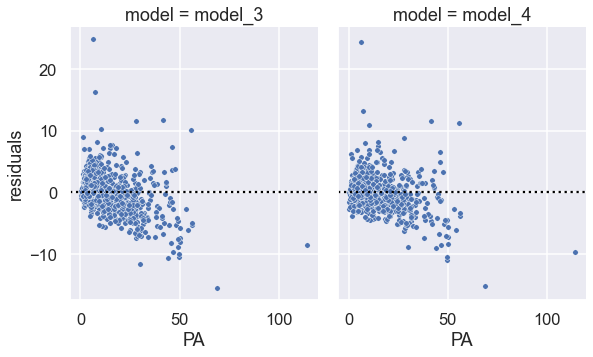

In [289]:
plot_residuals([model_3, model_4])

From the residual plot, we can see that Model 4's residuals are generally
closer to 0.
Model 4's residuals trend downward less than Model 3's, indicating a better
model fit.

After fitting the model, we have:
$ \hat \theta_0 = 5.77 $, $ \hat \theta_1 = 0.524 $, and
$ \hat \theta_2 = -0.0860 $
so our fitted model predicts:

$$
\begin{aligned}
f_{\hat \theta}(x) = 5.77 + 0.524 \cdot \text{PA} - 0.086 \cdot \text{RH}
\end{aligned}
$$

And thus, we've achieved our goal:
we have a model to correct PurpleAir PM2.5 measurements!
From our analysis, this model achieves a test set error of 2.58 µg m⁻³,
which is a useful improvement over our baseline models.
If the model can maintain this error rate for real-world data,
it should be practically useful---for instance, a "moderate" PM2.5 level
corresponds to 12-35 µg m⁻³, while a "unhealthy for sensitive groups"
PM2.5 level corresponds to 35-55 µg m⁻³ {cite}`usepaAQI2016`.
Our residual plot shows that applying our correction to PurpleAir sensors
makes most measurements within 5 µg m⁻³ away from the true PM2.5,
so we can reasonably recommend using PurpleAir sensors to report air quality.